In [1]:
from os import path
from random import random

import pandas as pd
import pytorch_lightning as pl
import torch
import torchaudio
from sklearn.model_selection import train_test_split
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

from dataset import WindowedFeatureDataset
from model.entrainment import FixedHistoryEntrainmentModel


/home/mmcneil/src/neural-entrainment/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tail_length = -1
history = "self"
attention = False
corpus_dir = "/home/mmcneil/datasets/fisher_corpus"
epochs = 10
batch_size = 128
input_features = [
    "intensity_mean_norm",
    "pitch_range_norm",
    "rate_norm",
    "duration_norm",
]
output_features = ["pitch_range_norm"]  # input_features
feature_dir = "data/fisher"
feature_idx = dict((v, k) for (k, v) in enumerate(input_features))


In [3]:
df_turns = pd.read_csv(path.join(feature_dir, "turns_norm.csv"))
df_turns = df_turns.set_index("ses_id")


In [4]:
class FeatureDataset(Dataset):
    def __init__(self, df, idxs, X_features, target):
        super().__init__()

        self.df = df
        self.idxs = idxs

        self.X_features = X_features
        self.target = target

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        ses_id = self.idxs[idx]
        X_data = self.df.loc[ses_id]
        X_features = torch.FloatTensor(X_data[self.X_features].values)
        y_features = torch.FloatTensor(X_data[self.target].values)
        speaker = torch.FloatTensor(
            [[1, 0] if x == "A" else [0, 1] for x in X_data["speaker"].values]
        )

        X_features = X_features[:-1]
        X_speaker = speaker[:-1]
        y_features = y_features[1:]
        y_speaker = speaker[1:]

        return (
            X_features,
            X_speaker,
            torch.LongTensor([len(X_features)]),
            y_features,
            y_speaker,
            torch.LongTensor([len(y_features)]),
        )


def collate_fn(batch):
    X_features = nn.utils.rnn.pad_sequence([x[0] for x in batch], batch_first=True)
    X_speaker = nn.utils.rnn.pad_sequence([x[1] for x in batch], batch_first=True)
    X_len = torch.LongTensor([x[2] for x in batch])
    y_features = nn.utils.rnn.pad_sequence([x[3] for x in batch], batch_first=True)
    y_speaker = nn.utils.rnn.pad_sequence([x[4] for x in batch], batch_first=True)
    y_len = torch.LongTensor([x[5] for x in batch])

    return X_features, X_speaker, X_len, y_features, y_speaker, y_len


In [5]:
idxs, test_idx = train_test_split(
    list(df_turns.index.unique()), train_size=0.8, random_state=9001
)
test_idx, val_idx = train_test_split(test_idx, test_size=0.5, random_state=9001)

train_dataset = FeatureDataset(
    df_turns,
    idxs,
    input_features,
    output_features,
)
test_dataset = FeatureDataset(
    df_turns,
    test_idx,
    input_features,
    output_features,
)

val_dataset = FeatureDataset(
    df_turns,
    val_idx,
    input_features,
    output_features,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True,
    drop_last=True,
    num_workers=16,
    persistent_workers=True,
    collate_fn=collate_fn,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=16,
    persistent_workers=True,
    collate_fn=collate_fn,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=128,
    shuffle=False,
    drop_last=False,
    num_workers=16,
    persistent_workers=True,
    collate_fn=collate_fn,
)


In [29]:
class EntrainmentModel(pl.LightningModule):
    def __init__(
        self,
        lr=0.0001,
        rnn_in_dim=3,
        rnn_out_dim=64,
        out_dim=1,
        has_attention=False,
        teacher_forcing=0.5,
        max_length=512,
        outputs=None,
        dropout=0.5,
        att_dim=128,
        feature_idx=feature_idx,
        teacher_forcing_schedule=False,
        teacher_forcing_end=0.5,
        teacher_forcing_schedule_start_epochs=10,
        teacher_forcing_schedule_transition_epochs=10,
    ):
        super().__init__()

        self.lr = lr
        self.teacher_forcing = teacher_forcing
        self.teacher_forcing_start = teacher_forcing
        self.teacher_forcing_schedule = teacher_forcing_schedule
        self.teacher_forcing_end = teacher_forcing_end
        self.teacher_forcing_schedule_start_epochs = (
            teacher_forcing_schedule_start_epochs
        )
        self.teacher_forcing_schedule_transition_epochs = (
            teacher_forcing_schedule_transition_epochs
        )
        self.max_length = max_length
        self.rnn_out_dim = rnn_out_dim

        if has_attention:
            raise NotImplementedError("Attention not implemented")

        self.att_w1 = nn.Linear(rnn_out_dim, att_dim, bias=False)
        self.att_w2 = nn.Linear(rnn_out_dim, att_dim, bias=False)
        self.att_v = nn.Linear(att_dim, 1, bias=False)

        self.hidden_dim = rnn_out_dim

        self.prenet = nn.Linear(rnn_in_dim + 4, rnn_out_dim)
        self.rnn1 = nn.LSTMCell(rnn_out_dim, rnn_out_dim)
        self.rnn2 = nn.LSTMCell(rnn_out_dim, rnn_out_dim)

        self.decoder_rnn_1 = nn.LSTMCell(rnn_out_dim, rnn_out_dim)
        self.decoder_rnn_2 = nn.LSTMCell(rnn_out_dim, rnn_out_dim)

        self.linear = nn.Linear(rnn_out_dim * 2, out_dim)

        self.dropout = nn.Dropout(dropout)

        self.outputs = outputs
        if outputs is not None:
            self.output_idxs = torch.LongTensor(
                [feature_idx[output] for output in outputs]
            )

    def training_epoch_end(self, outputs):
        self.log("teacher_forcing", self.teacher_forcing, on_epoch=True)

        teacher_forcing_epoch = (
            self.current_epoch - self.teacher_forcing_schedule_start_epochs
        )

        if (
            teacher_forcing_epoch > 0
            and teacher_forcing_epoch < self.teacher_forcing_schedule_transition_epochs
        ):
            diff = self.teacher_forcing_start - self.teacher_forcing_end
            diff /= self.teacher_forcing_schedule_transition_epochs
            self.teacher_forcing -= diff

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def validation_step(self, batch, batch_idx):
        X_features, X_speaker, X_len, y_features, y_speaker, y_len = batch
        y_pred, att = self(X_features, X_len, X_speaker, y_speaker, teacher_forcing=0.0)
        loss = F.smooth_l1_loss(y_pred, y_features)

        self.log("val_loss", loss.detach(), on_epoch=True, on_step=True)

        return loss

    def predict_step(self, batch, batch_idx):
        X_features, X_speaker, X_len, y_features, y_speaker, y_len = batch
        y_pred, att = self(X_features, X_len, X_speaker, y_speaker, teacher_forcing=0.0)

        return y_pred

    def training_step(self, batch, batch_idx):
        X_features, X_speaker, X_len, y_features, y_speaker, y_len = batch
        y_pred, att = self(
            X_features,
            X_len,
            X_speaker,
            y_speaker,
            teacher_forcing=self.teacher_forcing,
        )

        loss = F.mse_loss(y_pred, y_features)

        self.log("train_loss", loss.detach(), on_epoch=True, on_step=True)

        return loss

    def forward(self, X_features, X_len, X_speaker, y_speaker, teacher_forcing=0.5):
        batch_size = X_features.shape[0]
        max_len = X_len.max()

        mask = torch.arange(max_len, device=self.device).unsqueeze(0).repeat(
            len(X_len), 1
        ) >= X_len.unsqueeze(1)
        mask = mask.unsqueeze(2)

        h1 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        c1 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        h2 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        c2 = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        decoder_h_1 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        decoder_c_1 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        decoder_h_2 = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        decoder_c_2 = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        out = []
        rnn_out = torch.zeros(batch_size, max_len, self.rnn_out_dim, device=self.device)

        prev_out = None
        all_weights = []
        for i in range(max_len):
            if prev_out is not None and random() > teacher_forcing:
                if self.outputs is None:
                    input = prev_out
                else:
                    input = X_features[:, i]
                    input[:, self.output_idxs] = prev_out.type_as(input)
            else:
                input = X_features[:, i]

            input = torch.cat([input, X_speaker[:, i], y_speaker[:, i]], dim=-1)

            input = F.relu(self.prenet(input))

            h1, c1 = self.rnn1(input, (h1, c1))
            h1 = self.dropout(h1)
            h2, c2 = self.rnn2(h1, (h2, c2))
            h2 = self.dropout(h2)

            rnn_out[:, i] = h2

            decoder_h_1, decoder_c_1 = self.decoder_rnn_1(
                h2, (decoder_h_1, decoder_c_1)
            )
            decoder_h_1 = self.dropout(decoder_h_1)
            decoder_h_2, decoder_c_2 = self.decoder_rnn_2(
                decoder_h_1, (decoder_h_2, decoder_c_2)
            )
            decoder_h_2 = self.dropout(decoder_h_2)

            w1 = self.att_w1(rnn_out[:, : i + 1])
            w2 = self.att_w2(decoder_h_2).unsqueeze(1)
            score = self.att_v(torch.tanh(w1 + w2))

            score = score.masked_fill(mask[:, : i + 1], float("-inf"))
            score = F.softmax(score, dim=1)
            all_weights.append(score.detach().unsqueeze(1))
            score = score.squeeze(-1)

            score = score.unsqueeze(1)
            att_applied = torch.bmm(score, rnn_out[:, : i + 1])
            att_applied = att_applied.squeeze(1)

            h_out = self.linear(torch.cat([decoder_h_2, att_applied], dim=1))
            out.append(h_out.unsqueeze(1))
            prev_out = h_out.detach()

        out = torch.cat(out, dim=1)
        out = out.masked_fill(mask, 0)

        return out, all_weights


model = EntrainmentModel(
    lr=0.0001,
    rnn_in_dim=len(input_features),
    rnn_out_dim=32,
    out_dim=1,  # len(output_features),
    has_attention=False,
    teacher_forcing=0.0,
    dropout=0.0,
    outputs=["pitch_range_norm"],
)

for x in test_dataloader:
    model.training_step(x, 0)
    break


In [31]:
model = EntrainmentModel(
    lr=0.00001,
    rnn_in_dim=len(input_features),
    rnn_out_dim=32,
    att_dim=128,
    out_dim=1,  # len(output_features),
    has_attention=False,
    teacher_forcing=1.0,
    dropout=0.0,
    outputs=["pitch_range_norm"],
    teacher_forcing_schedule=True,
    teacher_forcing_end=0.5,
    teacher_forcing_schedule_start_epochs=10,
    teacher_forcing_schedule_transition_epochs=10,
)

trainer = pl.Trainer(accelerator="gpu", devices=[0], precision=16, max_epochs=-1)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name          | Type     | Params
-------------------------------------------
0 | att_w1        | Linear   | 4.1 K 
1 | att_w2        | Linear   | 4.1 K 
2 | att_v         | Linear   | 128   
3 | prenet        | Linear   | 288   
4 | rnn1          | LSTMCell | 8.4 K 
5 | rnn2          | LSTMCell | 8.4 K 
6 | decoder_rnn_1 | LSTMCell | 8.4 K 
7 | decoder_rnn_2 | LSTMCell | 8.4 K 
8 | linear        | Linear   | 65    
9 | dropout       | Dropout  | 0     
-------------------------------------------
42.5 K    Trainable params
0         Non-trainable params
42.5 K    Total params
0.085     Total estimated model params size (MB)


Epoch 14:  10%|▉         | 8/83 [00:04<00:38,  1.93it/s, loss=0.545, v_num=146] 

/home/mmcneil/src/neural-entrainment/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [44]:
teacher_forcing=1.0
teacher_forcing_end=0.5
teacher_forcing_schedule_start_epochs=10
teacher_forcing_schedule_transition_epochs=10

teacher_forcing_start = teacher_forcing

for current_epoch in range(50):
    teacher_forcing_epoch = (
        current_epoch - teacher_forcing_schedule_start_epochs
    )

    if (
        teacher_forcing_epoch > 0
        and teacher_forcing_epoch <= teacher_forcing_schedule_transition_epochs
    ):
        diff = teacher_forcing_start - teacher_forcing_end
        diff /= teacher_forcing_schedule_transition_epochs
        teacher_forcing -= diff

    print(i, teacher_forcing)

49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 1.0
49 0.95
49 0.8999999999999999
49 0.8499999999999999
49 0.7999999999999998
49 0.7499999999999998
49 0.6999999999999997
49 0.6499999999999997
49 0.5999999999999996
49 0.5499999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996
49 0.4999999999999996


In [8]:
from matplotlib import pyplot as plt


In [23]:
model = EntrainmentModel.load_from_checkpoint(
    "lightning_logs/version_140/checkpoints/epoch=55-step=4088.ckpt",
    lr=0.00001,
    rnn_in_dim=len(input_features),
    rnn_out_dim=128,
    out_dim=1,  # len(output_features),
    has_attention=False,
    teacher_forcing=0.5,
    dropout=0.5,
    outputs=["pitch_range_norm"],
)

RuntimeError: Error(s) in loading state_dict for EntrainmentModel:
	Unexpected key(s) in state_dict: "att_w1.bias", "att_w2.bias", "att_v.bias". 

In [32]:
model = model.cuda()
for batch in test_dataloader:
    X_features, X_speaker, X_len, y_features, y_speaker, y_len = batch
    y_pred, att = model(
        X_features.cuda(),
        X_len.cuda(),
        X_speaker.cuda(),
        y_speaker.cuda(),
        teacher_forcing=0.0,
    )

    break


In [33]:
att_together = nn.utils.rnn.pad_sequence(
    [x.swapaxes(0, 3).squeeze(0).squeeze(0) for x in att]
).swapaxes(0, 2)


In [34]:
att[2]


tensor([[[[0.3247],
          [0.3345],
          [0.3407]]],


        [[[0.3250],
          [0.3343],
          [0.3407]]],


        [[[0.3245],
          [0.3346],
          [0.3409]]],


        [[[0.3247],
          [0.3344],
          [0.3409]]],


        [[[0.3247],
          [0.3345],
          [0.3408]]],


        [[[0.3243],
          [0.3348],
          [0.3409]]],


        [[[0.3239],
          [0.3348],
          [0.3413]]],


        [[[0.3249],
          [0.3346],
          [0.3405]]],


        [[[0.3245],
          [0.3347],
          [0.3408]]],


        [[[0.3246],
          [0.3345],
          [0.3409]]],


        [[[0.3250],
          [0.3342],
          [0.3408]]],


        [[[0.3251],
          [0.3346],
          [0.3403]]],


        [[[0.3248],
          [0.3345],
          [0.3407]]],


        [[[0.3248],
          [0.3341],
          [0.3411]]],


        [[[0.3243],
          [0.3347],
          [0.3410]]],


        [[[0.3242],
          [0.3348],


In [39]:
att_together[62, 160]


tensor([0.0058, 0.0059, 0.0060, 0.0061, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0063, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062, 0.0062,
        0.0062, 0.0062, 0.0062, 0.0062, 

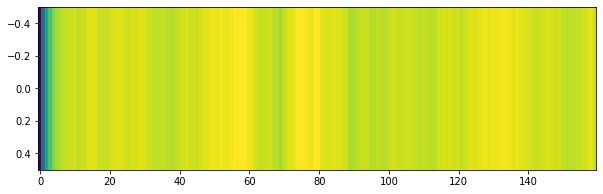

In [38]:
x = 160
plt.figure(figsize=(10, 3))
plt.imshow(
    att_together[62, x].unsqueeze(0).cpu()[:,:x], interpolation="nearest", aspect="auto"
)
plt.show()
